# pems-bay.h5

In [62]:
import h5py
import pickle
import folium
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [63]:
with h5py.File('data/PEMS-BAY/pems-bay.h5', 'r') as file:

    axis0 = file['speed']['axis0'][:]               # Идентификаторы датчиков
    block0_items = file['speed']['block0_items'][:] # Идентификаторы датчиков
    axis1 = file['speed']['axis1'][:]               # Метки времени
    timestamps = pd.to_datetime(axis1)              # Преобразование меток времени в формат datetime
    speed_data = file['speed']['block0_values'][:]  # Данные замеров скорости

perms_bay = pd.DataFrame(speed_data, index=timestamps, columns=axis0)

In [67]:
perms_bay[:2016].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2017-01-01 00:00:00 to 2017-01-07 23:55:00
Columns: 325 entries, 400001 to 414694
dtypes: float64(325)
memory usage: 5.0 MB


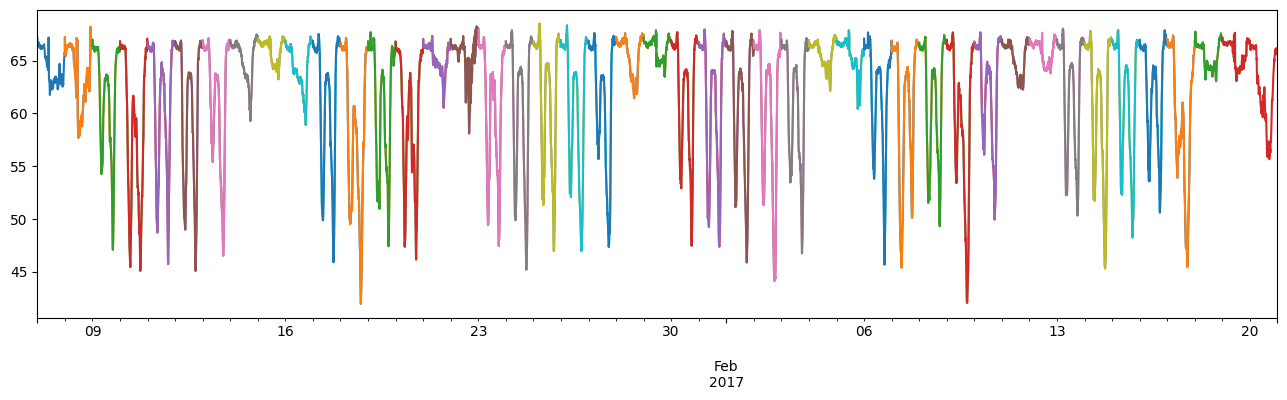

In [7]:
slice = 24 * 60 // 5

# for i in range(7):
#     perms_bay.mean(axis=1)[slice*(i):slice*(i+1)].plot(figsize=(16, 4))

for i in range(6, 50):
    perms_bay.mean(axis=1)[slice*(i):slice*(i+2)].plot(figsize=(16, 4))

In [3]:
# Открытие .pkl файла
with open('data/PEMS-BAY/adj_mx_bay.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

In [4]:
node_ids = [x.decode('utf-8') for x in data[0]]                     # Получаем список id узлов из data[0]
adj_matrix = data[2]                                                # Получаем матрицу смежности из data[2]
adj_df = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids) # Создание DataFrame с использованием id узлов как индексов и названий колонок

In [5]:
distances_df = pd.read_csv('data/PEMS-BAY/distances_bay_2017.csv', header=None)
locations_df = pd.read_csv('data/PEMS-BAY/graph_sensor_locations_bay.csv', header=None)

In [11]:
distances_df

0       1       2
0     400001  400001     0.0
1     400017  400017     0.0
2     400030  400030     0.0
3     400030  400045  5108.4
4     400030  400065  7401.1
...      ...     ...     ...
8353  414694  405701  1016.7
8354  414694  407710  2290.3
8355  414694  408907  8610.4
8356  414694  408911  9119.3
8357  414694  414694     0.0

[8358 rows x 3 columns]

In [ ]:
# Создание графа
G = nx.Graph()

# Добавление узлов с координатами
for _, row in locations_df.iterrows():
    node_id = row[0]
    x, y = row[1], row[2]
    G.add_node(str(int(node_id)), pos=(x, y))

# Добавление рёбер на основе матрицы смежности
for node1 in adj_df.index:
    for node2 in adj_df.columns:
        weight = adj_df.loc[node1, node2]
        if weight != 0 and node1 != node2:  # Добавляем ребро только если вес не равен 0
            G.add_edge(node1, node2, weight=weight)

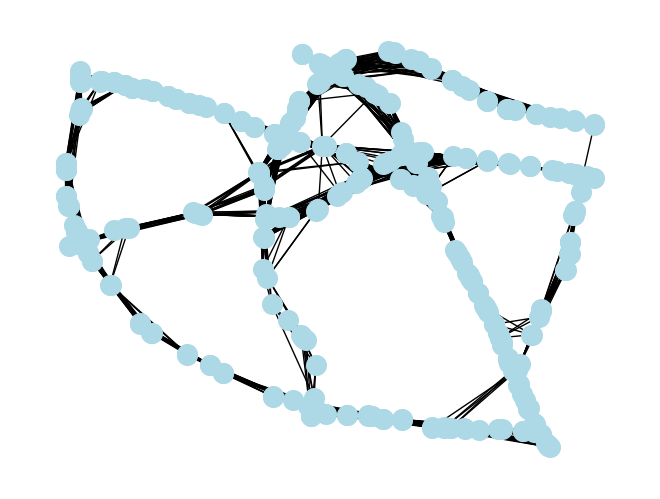

In [31]:
# Визуализация графа с использованием координат
pos = nx.get_node_attributes(G, 'pos')  # получаем координаты
nx.draw(G, pos, with_labels=False, node_size=200, node_color='lightblue', font_size=8)
plt.show()

In [32]:
# Создаем карту Folium, центрируем её на одном из узлов
m = folium.Map(location=[37.359087, -121.906538], zoom_start=13)

# Добавляем узлы на карту
for node, data in G.nodes(data=True):
    folium.Circle(location=[data['pos'][0], data['pos'][1]], popup=str(node)).add_to(m)

# Добавляем рёбра на карту
for edge in G.edges(data=True):
    node1 = edge[0]
    node2 = edge[1]
    
    # Координаты двух узлов
    loc1 = G.nodes[node1]['pos']
    loc2 = G.nodes[node2]['pos']
    
    # Рисуем линию между узлами
    folium.PolyLine(locations=[(loc1[0], loc1[1]), (loc2[0], loc2[1])], color='gray', weight=2.5, opacity=0.7).add_to(m)

# Отображаем карту
# m.save('graph_map.html')
m

# METR-LA

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import folium
import ast
import h5py
import pickle

In [2]:
# Загрузка данных
edges = pd.read_csv('data/METR-LA/METR_LA.rel')  # Укажите путь к файлу edges
nodes = pd.read_csv('data/METR-LA/METR_LA.geo')  # Укажите путь к файлу nodes
data_df = pd.read_csv('data/METR-LA/METR_LA.dyna')

# Преобразование строки координат в список
nodes['coordinates'] = nodes['coordinates'].apply(ast.literal_eval)

# Открытие .pkl файла
with open('data/METR-LA/adj_mx.pkl', 'rb') as file:
    data = pickle.load(file, encoding='bytes')

In [122]:
node_ids = [str(x.decode('utf-8')) for x in data[0]]                # Получаем список id узлов из data[0]
adj_matrix = data[2]                                                # Получаем матрицу смежности из data[2]
adj_df = pd.DataFrame(adj_matrix, index=node_ids, columns=node_ids) # Создание DataFrame с использованием id узлов как индексов и названий колонок

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Remove loops by zeroing the diagonal
np.fill_diagonal(adj_df.values, 0)

# Step 2: Convert to a graph using NetworkX
G = nx.from_pandas_adjacency(adj_df)

# Step 3: Compute Laplacian matrix
laplacian_matrix = nx.laplacian_matrix(G).toarray()

# Step 4: Calculate eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(laplacian_matrix)

# Step 5: Visualize eigenvalues and explain results
plt.figure(figsize=(8, 6))
plt.plot(range(len(eigvals)), eigvals, 'o-', label='Eigenvalues of Laplacian')
plt.title('Eigenvalues of Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid()
plt.legend()
plt.show()

# Returning the first few eigenvalues and eigenvectors for analysis
eigvals[:10], eigvecs[:, :3]  # Displaying the first 10 eigenvalues and first 3 eigenvectors


In [131]:
# Visualize graph structure, eigenvalues, and bottlenecks using the second eigenvector
def plot_graph_and_bottlenecks(G, eigvec):
    """
    Plot the graph and highlight bottleneck nodes based on the second eigenvector of the Laplacian.
    """
    # Nodes with extreme values in the second eigenvector (v1)
    bottleneck_nodes = [node for node, value in zip(G.nodes, eigvec) if value < -0.009]
    
    # Generate a layout for the graph
    pos = nx.spring_layout(G, seed=42)  # Spring layout for visualization

    # Plot the graph with default node colors
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=300, font_size=8, edge_color="gray")

    # Highlight bottleneck nodes (based on v1 values)
    nx.draw_networkx_nodes(G, pos, nodelist=bottleneck_nodes, node_color="red", node_size=500, label="Bottlenecks")
    
    plt.legend()
    plt.title("Graph Visualization with Bottleneck Nodes Highlighted")
    plt.show()

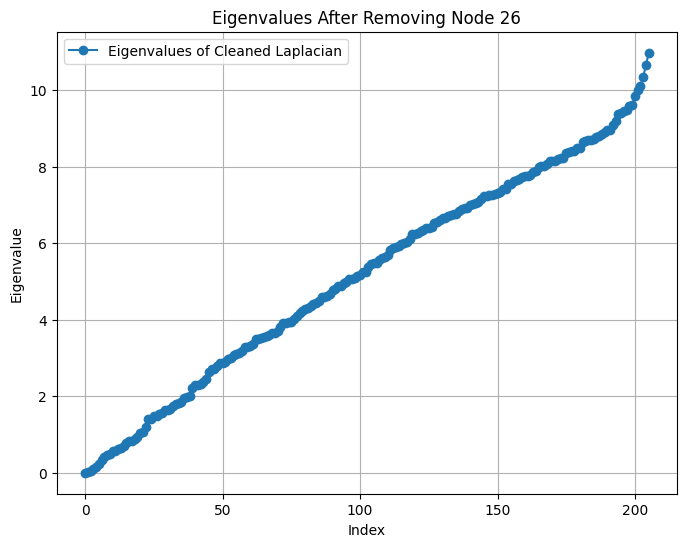

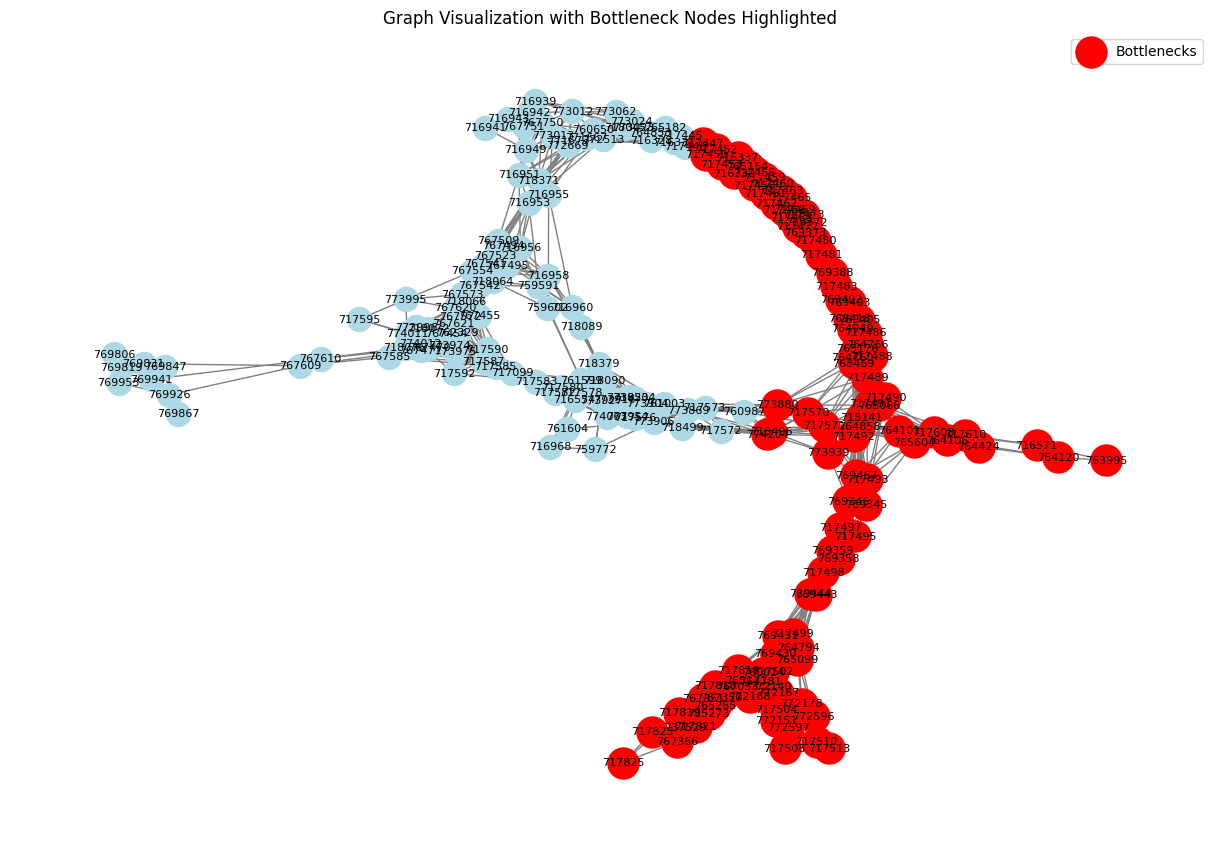

In [132]:
# Remove row and column corresponding to index 26 from the adjacency matrix
adj_matrix_cleaned = adj_df.drop(index='717804', columns='717804')

# Recreate the graph from the cleaned adjacency matrix
G_cleaned = nx.from_pandas_adjacency(adj_matrix_cleaned)

# Recalculate the Laplacian and its eigenvalues/eigenvectors
laplacian_matrix_cleaned = nx.laplacian_matrix(G_cleaned).toarray()
eigvals_cleaned, eigvecs_cleaned = np.linalg.eigh(laplacian_matrix_cleaned)

# Visualize eigenvalues of the cleaned Laplacian
plt.figure(figsize=(8, 6))
plt.plot(range(len(eigvals_cleaned)), eigvals_cleaned, 'o-', label='Eigenvalues of Cleaned Laplacian')
plt.title('Eigenvalues After Removing Node 26')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid()
plt.legend()
plt.show()

# Plot the graph again with bottlenecks using the second eigenvector
plot_graph_and_bottlenecks(G_cleaned, eigvecs_cleaned[:, 1])


In [130]:
pd.DataFrame(eigvecs_cleaned)

0         1         2         3         4         5         6    \
0   -0.069673  0.003840 -0.037325  0.058100 -0.048600  0.088187 -0.078721   
1   -0.069673  0.021058 -0.058126  0.069192  0.029607 -0.060634  0.047435   
2   -0.069673  0.022843 -0.057729  0.076902  0.025540 -0.058290  0.056758   
3   -0.069673 -0.009700 -0.043970 -0.096951  0.055783 -0.005837 -0.002733   
4   -0.069673 -0.008995 -0.045054 -0.095085  0.058974 -0.012047 -0.009633   
..        ...       ...       ...       ...       ...       ...       ...   
201 -0.069673  0.024670 -0.055083  0.100498  0.000788 -0.023871  0.070024   
202 -0.069673  0.027959 -0.060386  0.115508  0.015472 -0.077731  0.204995   
203 -0.069673 -0.066772  0.122801  0.033154  0.038144 -0.019457 -0.008657   
204 -0.069673 -0.026197  0.006513 -0.041151 -0.065250  0.074383  0.054702   
205 -0.069673 -0.015480 -0.030996 -0.096094  0.014370  0.045701  0.050366   

          7         8         9    ...           196           197  \
0    0.000688 -0.018021  0.000568  ...  1.594928e-07 -1.157194e-06   
1   -0.008190 -0.021115 -0.001889  ...  5.139623e-05 -2.364952e-10   
2   -0.005176 -0.014289 -0.001957  ... -3.375113e-05  4.469917e-11   
3    0.022361  0.069016 -0.000744  ...  3.800751e-02 -1.236852e-06   
4    0.017788  0.058129 -0.000545  ... -3.187124e-02 -6.034058e-07   
..        ...       ...       ...  ...           ...           ...   
201  0.012218  0.025623 -0.002060  ...  1.374206e-06 -5.564589e-10   
202  0.024777  0.059803 -0.010495  ... -1.921182e-07 -3.357922e-12   
203 -0.007071  0.013693 -0.000115  ... -1.042633e-07 -2.096949e-02   
204 -0.017655 -0.073640  0.000745  ...  3.267216e-04  2.659070e-05   
205  0.039289  0.092184 -0.001487  ... -1.064028e-01  1.910513e-05   

              198           199           200           201           202  \
0    2.120286e-04 -2.599924e-03  2.616186e-05  1.194117e-05 -1.087454e-05   
1    2.256659e-05 -3.398913e-07 -2.529501e-05 -1.381110e-05 -3.970753e-06   
2   -1.444129e-05  8.780924e-07  1.534096e-05  8.139186e-06  2.308212e-06   
3    5.784531e-02  4.378608e-03 -9.333839e-03 -1.661460e-02 -8.768663e-04   
4   -3.319665e-02 -3.992554e-03 -4.383422e-02  4.840875e-03 -1.426294e-02   
..            ...           ...           ...           ...           ...   
201  7.895077e-07 -4.441743e-06 -2.536567e-07 -1.146557e-07 -4.710628e-08   
202 -7.757421e-08  9.982706e-08  5.791685e-08  2.798629e-08  7.860136e-09   
203  8.558036e-07 -1.514110e-05  1.892024e-07  8.191710e-08 -8.352920e-08   
204 -2.001531e-03  2.736711e-02 -5.125425e-04 -2.132627e-04  3.281206e-04   
205  3.706107e-02  2.684028e-02 -1.277251e-01 -1.328286e-02  4.079962e-02   

              203           204           205  
0    1.637716e-05 -3.984631e-07  9.443645e-06  
1   -1.639873e-05  6.810330e-06 -1.286715e-06  
2    9.055908e-06 -3.583628e-06  6.435008e-07  
3   -3.942384e-02 -2.527917e-02  6.970230e-03  
4    1.866252e-02  2.063052e-02 -3.980025e-03  
..            ...           ...           ...  
201 -8.815136e-08  3.274553e-08  1.659164e-09  
202  2.616184e-08 -9.250612e-09  1.394805e-09  
203  9.773436e-08  5.155361e-10  3.598114e-08  
204 -4.449279e-04  6.439458e-07 -4.137374e-04  
205 -1.526228e-01  9.940389e-03  1.014429e-01  

[206 rows x 206 columns]

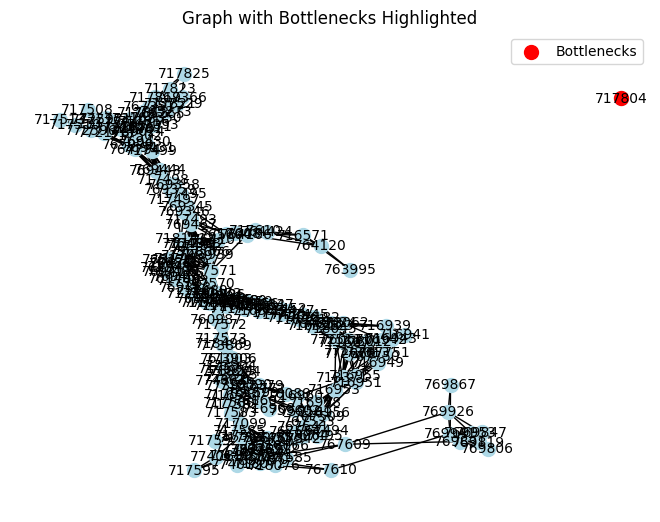

Собственные значения лапласиана:                 0
0   -1.206173e-15
1   -7.188988e-16
2    2.648295e-02
3    4.131844e-02
4    9.494994e-02
..            ...
202  1.000918e+01
203  1.010365e+01
204  1.035620e+01
205  1.065373e+01
206  1.097857e+01

[207 rows x 1 columns]


In [113]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Преобразуем в граф
# adj_df_copy = adj_df - np.eye(adj_df.shape[0])
# connected_nodes = adj_df_copy.sum(axis=1) > 0  # Узлы, которые имеют хотя бы одно ребро
# adj_df_copy = adj_df_copy.loc[connected_nodes, connected_nodes]
# adj_df_copy = adj_df_copy + np.eye(adj_df_copy.shape[0])
G = nx.from_pandas_adjacency(adj_df)

# 2. Вычисляем лапласиан
laplacian_matrix = nx.laplacian_matrix(G).toarray()

# 3. Находим собственные значения и векторы
eigvals, eigvecs = np.linalg.eigh(laplacian_matrix)

# 4. Визуализация графа и узких мест
def plot_graph_with_bottlenecks(G, eigvec):
    # Узкие места: выбираем вершины с минимальными значениями второго собственного вектора
    bottleneck_nodes = [n for n, val in zip(G.nodes, eigvec) if val < 0]

    # Рисуем граф
    pos = nx.spring_layout(G)  # Используем весеннюю раскладку
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=100, font_size=10)
    
    # Выделяем узкие места
    nx.draw_networkx_nodes(G, pos, nodelist=bottleneck_nodes, node_color="red", node_size=100, label="Bottlenecks")
    plt.legend()
    plt.title("Graph with Bottlenecks Highlighted")
    plt.show()

# Используем второй собственный вектор (eigvecs[:, 1])
plot_graph_with_bottlenecks(G, eigvecs[:, 1])

# 5. Выводим собственные значения
print("Собственные значения лапласиана:", pd.DataFrame(eigvals))

In [100]:
eigvals[0] - eigvals[1]

0.32484175689510586

In [4]:
data_df = data_df.merge(nodes, left_on='entity_id', right_on='geo_id')

In [ ]:
data_df['geometry'] = data_df['coordinates'].apply(lambda x: Point(x[0], x[1])) # Создание колонки 'geometry' с объектами типа Point
geo_data_df = gpd.GeoDataFrame(data_df, geometry='geometry') # Преобразование DataFrame в GeoDataFrame
geo_data_df.set_crs(epsg=4326, inplace=True) # Установка CRS (например, WGS84 - EPSG:4326)

geo_data_df.drop_duplicates(subset=['entity_id']).explore()

In [36]:
# Создание графа
G = nx.Graph()

# Добавление узлов с координатами
for _, row in nodes.iterrows():
    node_id = str(int(row['geo_id']))
    pos = tuple(row['coordinates'])  # Преобразование координат в кортеж (долгота, широта)
    G.add_node(node_id, pos=pos)

# Добавление рёбер на основе матрицы смежности
for node1 in adj_df.index:
    for node2 in adj_df.columns:
        weight = adj_df.loc[node1, node2]
        if weight != 0 and node1 != node2:  # Добавляем ребро только если вес не равен 0
            G.add_edge(node1, node2, weight=weight)

In [ ]:
# Инициализация карты Folium
# Центруем на первой координате узлов
center_lat, center_lon = nodes['coordinates'][0][1], nodes['coordinates'][0][0]
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Добавление ребер как линий
for u, v, data in G.edges(data=True):
    origin_pos = G.nodes[u]['pos']
    destination_pos = G.nodes[v]['pos']
    folium.PolyLine(
        locations=[[origin_pos[1], origin_pos[0]], [destination_pos[1], destination_pos[0]]],  # Переворот на (широта, долгота)
        color='gray',
        weight=1,
        opacity=0.7
    ).add_to(m)
    
# Добавление узлов как кругов
for node, data in G.nodes(data=True):
    folium.Circle(
        location=[data['pos'][1], data['pos'][0]],  # Переворот на (широта, долгота)
        radius=30,  # Радиус круга в метрах
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
    ).add_to(m)


# Отображение карты
m

In [6]:
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

E:\Temp\ipykernel_16872\141466891.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


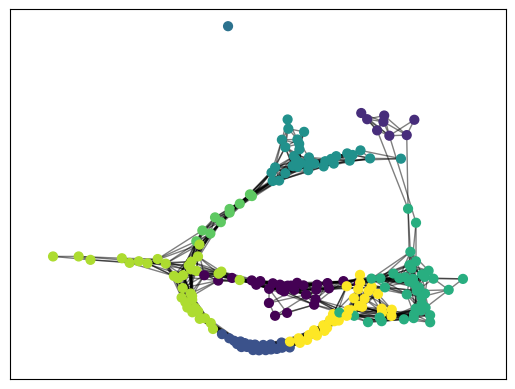

In [13]:
# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [8]:
from collections import defaultdict

In [9]:
dd = defaultdict(list)
for key, value in partition.items():
    dd[value].append(int(key))

In [10]:
traffic_df = data_df.pivot(columns='entity_id', values='traffic_speed', index='time')
traffic_df.replace(0, traffic_df.mean(), inplace=True)

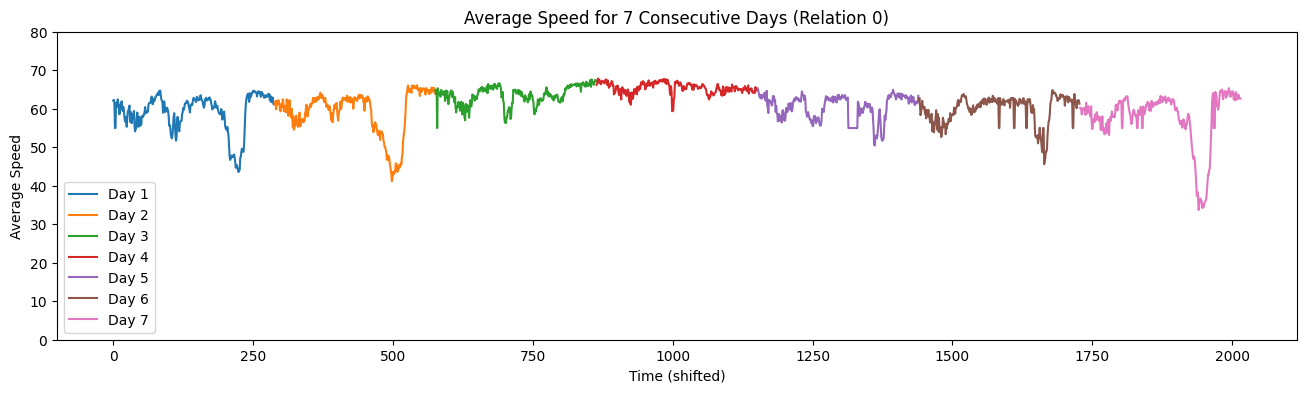

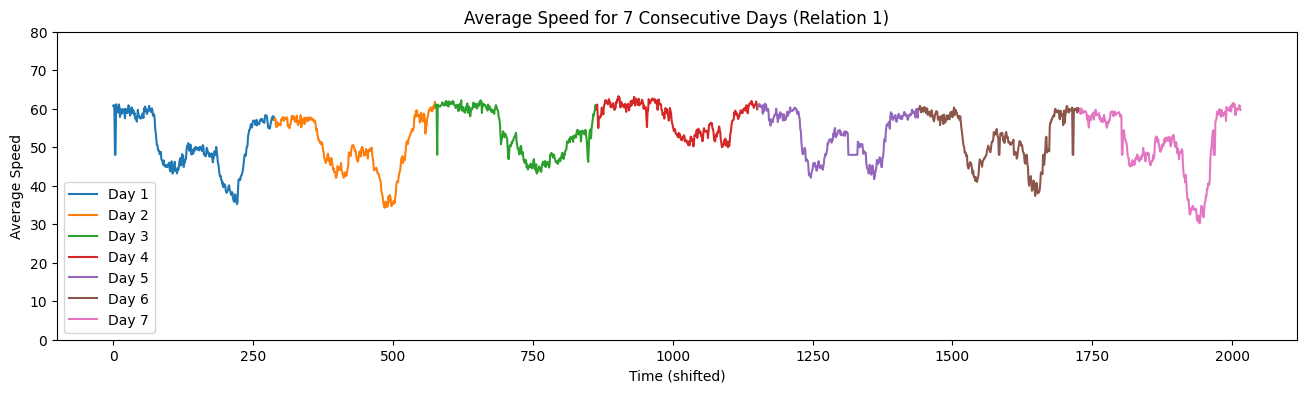

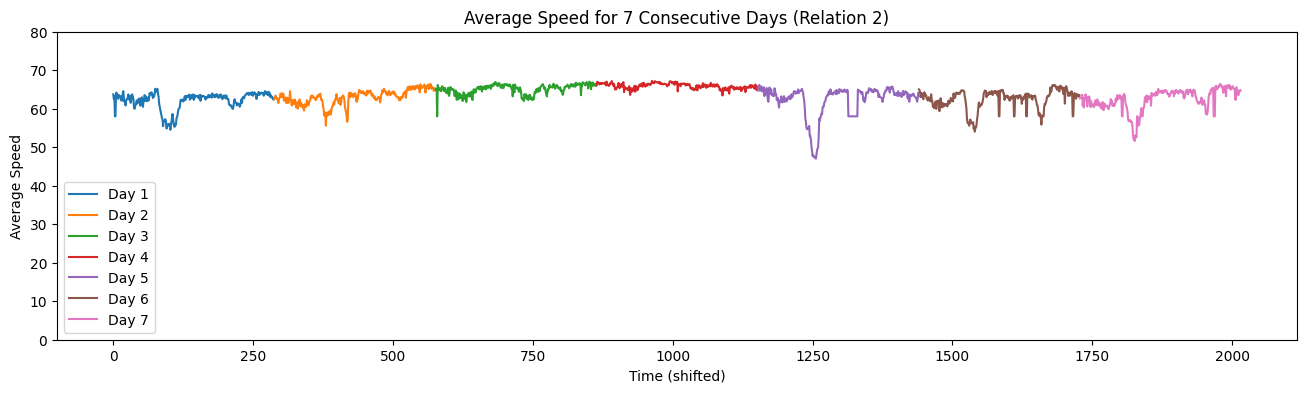

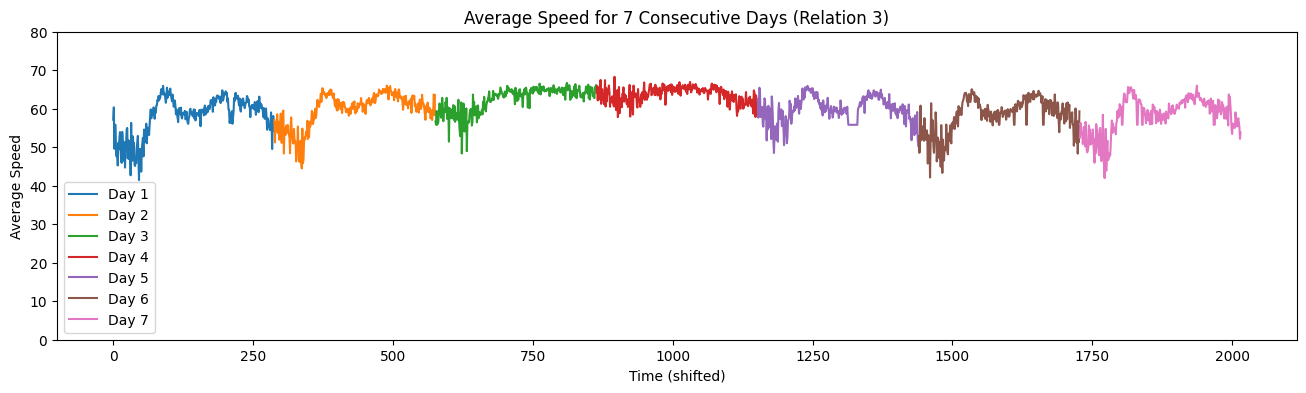

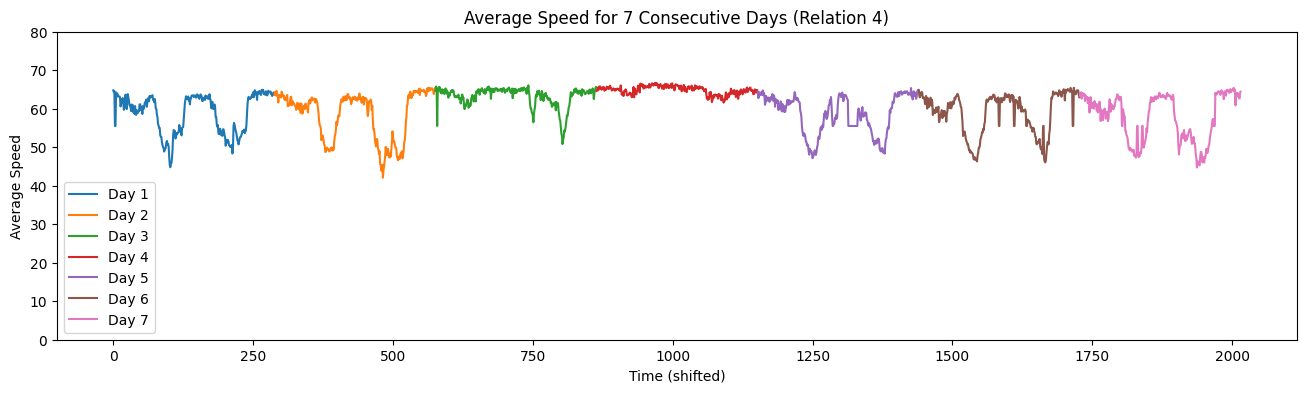

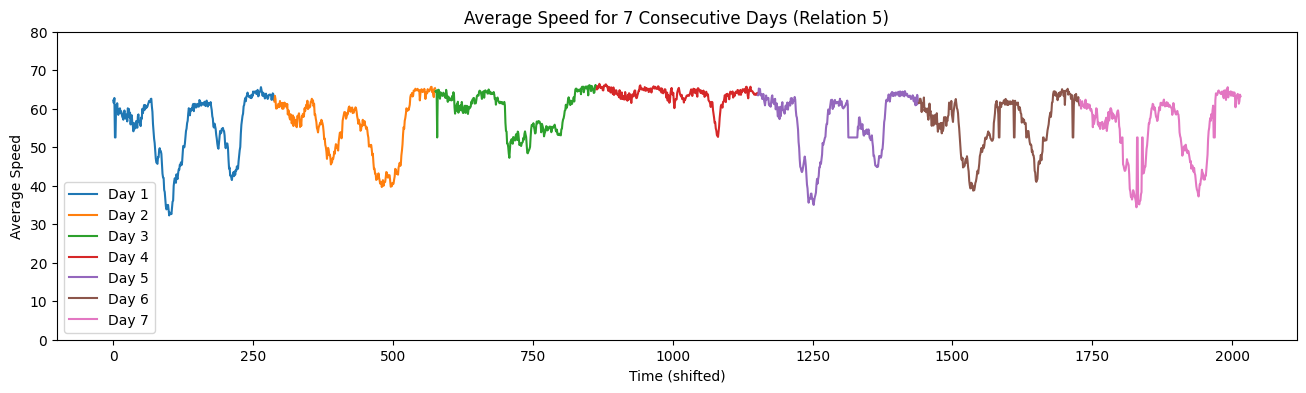

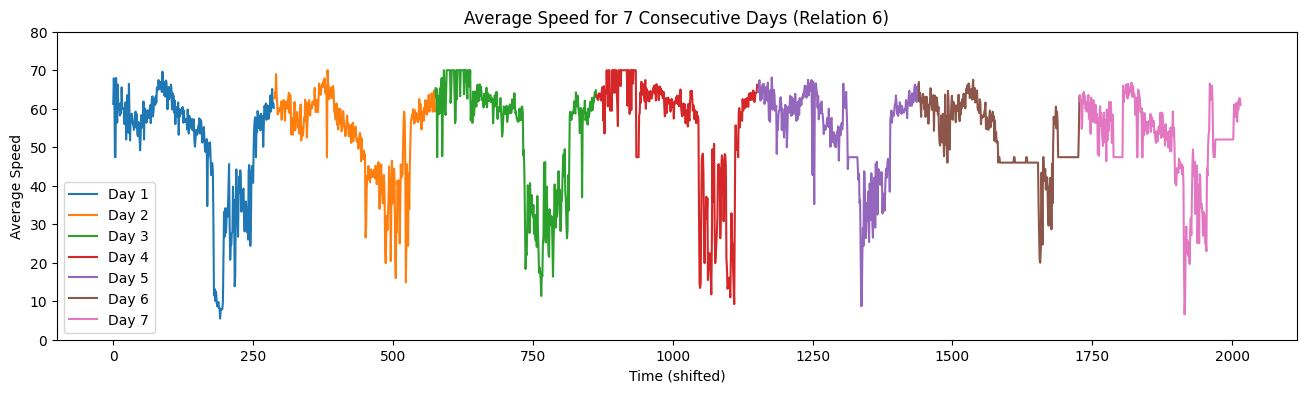

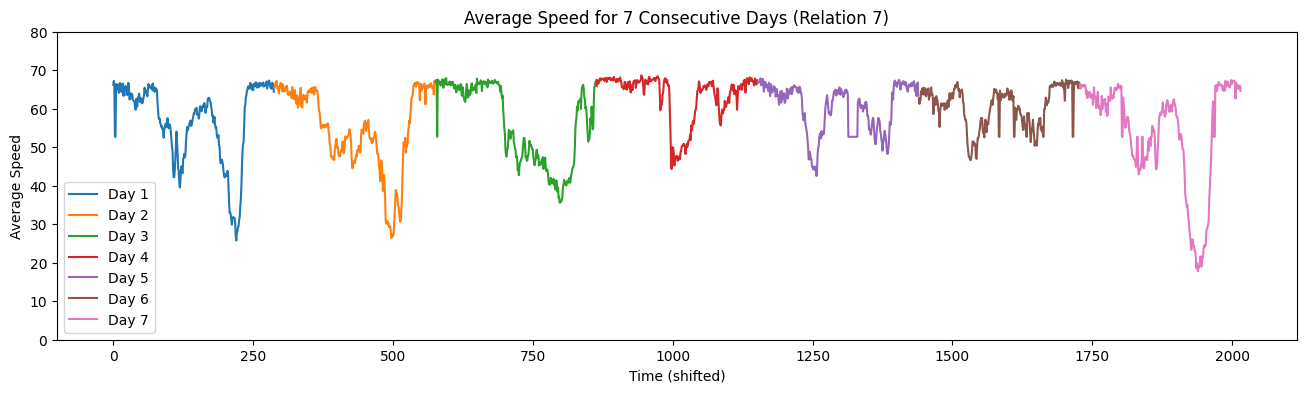

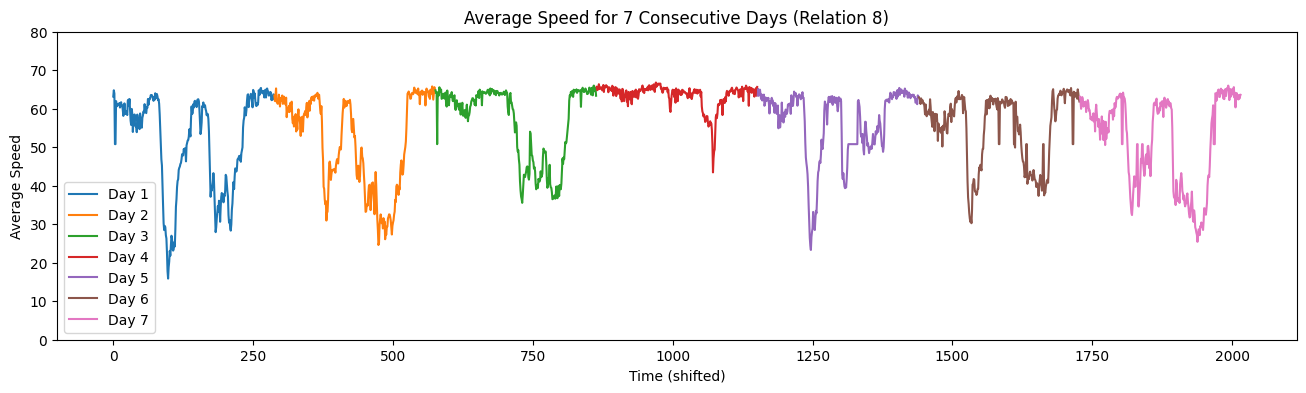

In [11]:
import matplotlib.pyplot as plt

# Параметры
slice = 24 * 60 // 5  # Количество интервалов за 1 день (при 5-минутном шаге)
days = 7              # Количество дней
relations = len(dd.keys())  # Количество групп узлов

for relation in range(relations):
    # Создаем график, на котором будут отображаться все 7 дней последовательно
    plt.figure(figsize=(16, 4))
    
    for day in range(days):
        start = slice * day
        end = slice * (day + 1)
        
        # Сдвигаем индекс, чтобы отобразить дни последовательно
        daily_mean = traffic_df[dd[relation]].mean(axis=1)[start:end]
        
        # Задаем ось x, чтобы временные метки не пересекались
        daily_mean.index = range(start, end)
        
        # Рисуем график для каждого дня
        daily_mean.plot(label=f'Day {day + 1}')
    
    # Настройка графика
    plt.ylim(0, 80)
    plt.xlabel("Time (shifted)")
    plt.ylabel("Average Speed")
    plt.title(f"Average Speed for 7 Consecutive Days (Relation {relation})")
    plt.legend()
    plt.show()


In [12]:
import os
import numpy as np
import pandas as pd

# Папка, куда будем сохранять файлы
output_folder = "T-GCN/T-GCN/T-GCN-PyTorch/data/"
os.makedirs(output_folder, exist_ok=True)  # Создаем папку, если ее еще нет


# Количество подграфов
lens = len(dd.keys())

# Проходим по каждому ключу в `dd`
for i in range(lens):
    # 1. Создаем подграф и матрицу смежности с единичной диагональю
    subG = G.subgraph([str(x) for x in dd[i]])
    subdf = pd.DataFrame(nx.to_numpy_array(subG, weight='weight')) + np.eye(len(dd[i]))
    subdf.columns = dd[i]
    
    # 2. Извлекаем соответствующую часть DataFrame для подграфа
    subtraffic = traffic_df[dd[i]][:2016]
    
    # 3. Сохраняем матрицу смежности в CSV
    subdf_path = os.path.join(output_folder, f"subgraph_matrix_{i}.csv")
    subdf.to_csv(subdf_path, index=False, header=False)
    
    # 4. Сохраняем часть traffic_df в отдельный CSV
    subtraffic_path = os.path.join(output_folder, f"subtraffic_{i}.csv")
    subtraffic.to_csv(subtraffic_path, index=False)
    
    print(f"Сохранены файлы для подграфа {i}:")
    print(f"- Матрица смежности: {subdf_path}")
    print(f"- Данные трафика: {subtraffic_path}")

Сохранены файлы для подграфа 0:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_0.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_0.csv
Сохранены файлы для подграфа 1:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_1.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_1.csv
Сохранены файлы для подграфа 2:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_2.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_2.csv
Сохранены файлы для подграфа 3:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_3.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_3.csv
Сохранены файлы для подграфа 4:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_4.csv
- Данные трафика: T-GCN/T-GCN/T-GCN-PyTorch/data/subtraffic_4.csv
Сохранены файлы для подграфа 5:
- Матрица смежности: T-GCN/T-GCN/T-GCN-PyTorch/data/subgraph_matrix_5.csv
- Данные трафика: T-GCN/T-GCN/T-GC

## Пробую преобразовать данные перед передачей в модель

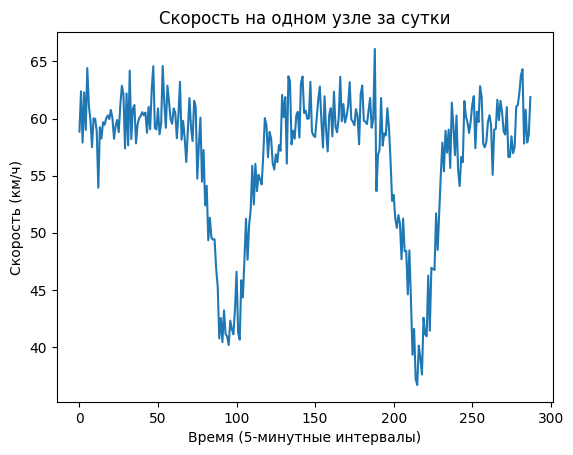

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных
time_steps = 288
base_speed = 60  # Средняя скорость
rush_hour_effect = lambda t: 20 * np.exp(-0.5 * ((t - 96) / 10)**2) + 20 * np.exp(-0.5 * ((t - 216) / 10)**2)  # Пики
speeds = base_speed - rush_hour_effect(np.arange(time_steps)) + np.random.normal(0, 2, time_steps)

# Визуализация
plt.plot(speeds)
plt.title("Скорость на одном узле за сутки")
plt.xlabel("Время (5-минутные интервалы)")
plt.ylabel("Скорость (км/ч)")
plt.show()


In [2]:
from sklearn.model_selection import train_test_split

# Параметры окна
window_size = 12
X = np.array([speeds[i:i+window_size] for i in range(len(speeds) - window_size)])
Y = speeds[window_size:]

# Разделение на обучение и тест
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [3]:
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
Y_train = (Y_train - mean) / std
Y_test = (Y_test - mean) / std


In [4]:
import torch
edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)  # Связи
edge_weights = torch.tensor([0.5, 0.8, 0.3], dtype=torch.float)  # Веса рёбер

In [5]:
from statsmodels.tsa.seasonal import STL

stl = STL(speeds, period=288)  # Периодичность = 1 сутки (288 интервалов)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid


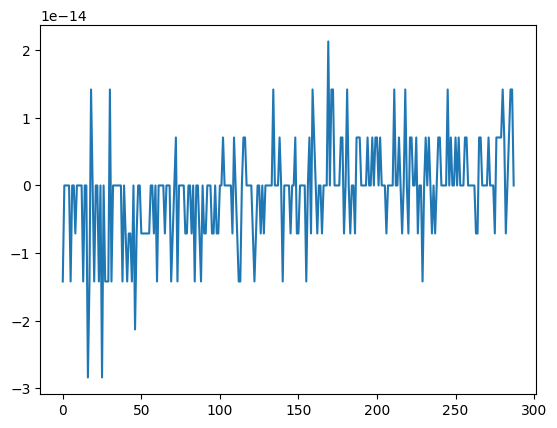

In [16]:
plt.plot(residual)
# plt.ylim(56, 57)
plt.show()

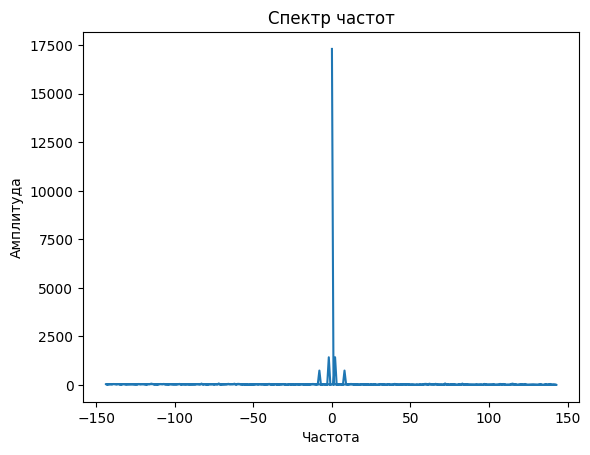

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Генерация данных
time_steps = 288
t = np.linspace(0, 1, time_steps)
speed = 60 + 10 * np.sin(2 * np.pi * 2 * t) + 5 * np.sin(2 * np.pi * 8 * t) + np.random.normal(0, 2, time_steps)

# Преобразование Фурье
fft_values = fft(speed)
frequencies = fftfreq(len(speed), d=1/time_steps)  # d=шаг по времени

# Визуализация спектра
plt.plot(frequencies[:time_steps], np.abs(fft_values[:time_steps]))
plt.title("Спектр частот")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()


Значимые частоты: [ 0.  2. -2.  8. -8.]


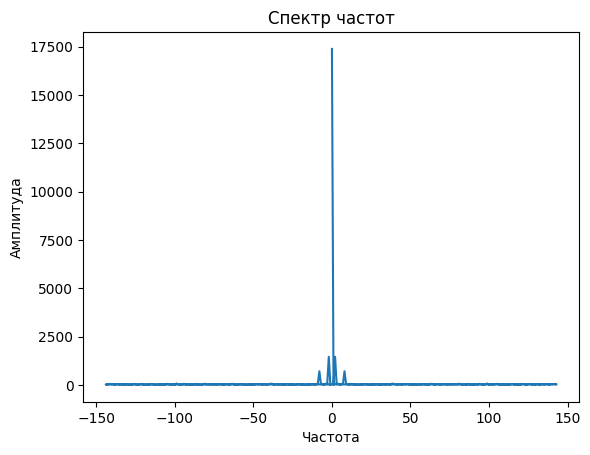

In [23]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

# Симулируем данные (можно заменить на ваши реальные данные)
time_steps = 288
t = np.linspace(0, 1, time_steps)
speed = 60 + 10 * np.sin(2 * np.pi * 2 * t) + 5 * np.sin(2 * np.pi * 8 * t) + np.random.normal(0, 2, time_steps)

# Преобразование Фурье
fft_values = fft(speed)
frequencies = fftfreq(len(speed), d=1/time_steps)

# Найдём частоты с наибольшими амплитудами
amplitudes = np.abs(fft_values)
significant_indices = np.argsort(amplitudes)[::-1]  # Индексы в порядке убывания амплитуд
significant_frequencies = frequencies[significant_indices[:5]]  # 5 наиболее значимых частот
print("Значимые частоты:", significant_frequencies[:5])

# Визуализация спектра
plt.plot(frequencies[:time_steps], amplitudes[:time_steps])
plt.title("Спектр частот")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()


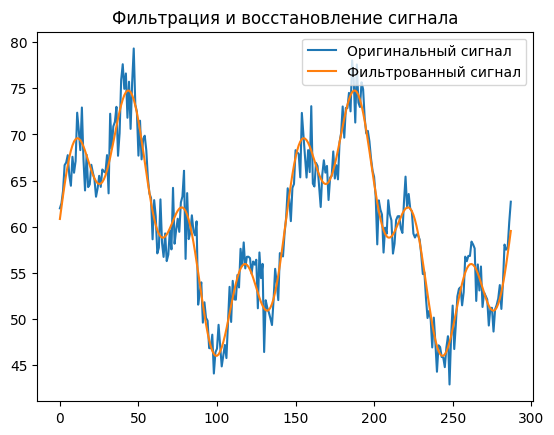

In [25]:
# Фильтруем только значимые частоты
filtered_fft = np.zeros_like(fft_values)
threshold = 500  # Порог для выбора частот
filtered_fft[amplitudes > threshold] = fft_values[amplitudes > threshold]

# Обратное преобразование
filtered_signal = ifft(filtered_fft).real

# Сравнение оригинального и сглаженного сигнала
plt.plot(speed, label="Оригинальный сигнал")
plt.plot(filtered_signal, label="Фильтрованный сигнал")
plt.legend()
plt.title("Фильтрация и восстановление сигнала")
plt.show()

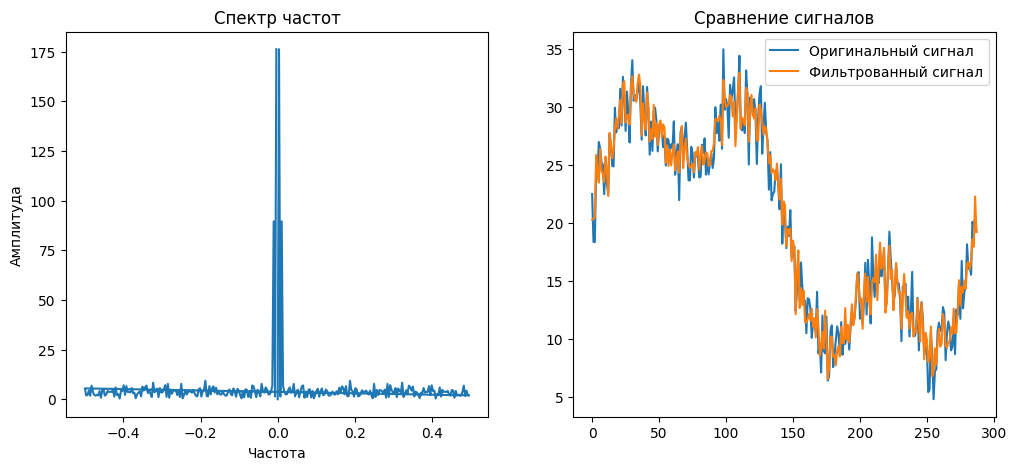

Значимые частоты: [ 0.00347222  0.01041667  0.01388889  0.02777778  0.03125     0.04166667
  0.0625      0.06597222  0.08333333  0.10416667  0.11458333  0.125
  0.15972222  0.16666667  0.17013889  0.17708333  0.1875      0.20138889
  0.20486111  0.25        0.27777778  0.28472222  0.29166667  0.30555556
  0.3125      0.32291667  0.34027778  0.34375     0.35069444  0.37847222
  0.39236111  0.39930556  0.42013889  0.48263889 -0.5        -0.48263889
 -0.42013889 -0.39930556 -0.39236111 -0.37847222 -0.35069444 -0.34375
 -0.34027778 -0.32291667 -0.3125     -0.30555556 -0.29166667 -0.28472222
 -0.27777778 -0.25       -0.20486111 -0.20138889 -0.1875     -0.17708333
 -0.17013889 -0.16666667 -0.15972222 -0.125      -0.11458333 -0.10416667
 -0.08333333 -0.06597222 -0.0625     -0.04166667 -0.03125    -0.02777778
 -0.01388889 -0.01041667 -0.00347222]


In [4]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

def process_speed_data(speed_data, threshold_std=0.9):
    """
    Выполняет Фурье-анализ, фильтрацию шума и восстановление сигнала.

    Параметры:
        speed_data (array): Временной ряд данных скорости.
        threshold_std (float): Порог для амплитуд в единицах стандартного отклонения (z-score).

    Возвращает:
        filtered_signal (array): Восстановленный сигнал после фильтрации.
        significant_frequencies (array): Частоты с амплитудами выше порога.
    """
    # 1. Стандартизация данных
    mean, std = np.mean(speed_data), np.std(speed_data)
    standardized_data = (speed_data - mean) / std

    # 2. Преобразование Фурье
    fft_values = fft(standardized_data)
    frequencies = fftfreq(len(standardized_data), d=1)  # d=шаг времени (можно адаптировать)
    amplitudes = np.abs(fft_values)

    # 3. Порог на основе стандартного отклонения
    threshold = threshold_std * np.std(amplitudes)
    filtered_fft = np.zeros_like(fft_values)
    filtered_fft[amplitudes > threshold] = fft_values[amplitudes > threshold]

    # 4. Обратное преобразование
    filtered_signal = ifft(filtered_fft).real

    # 5. Восстановление масштаба сигнала
    filtered_signal = filtered_signal * std + mean

    # 6. Значимые частоты
    significant_frequencies = frequencies[amplitudes > threshold]

    # 7. Визуализация
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(frequencies[:len(frequencies)], amplitudes[:len(frequencies)])
    plt.title("Спектр частот")
    plt.xlabel("Частота")
    plt.ylabel("Амплитуда")

    plt.subplot(1, 2, 2)
    plt.plot(speed_data, label="Оригинальный сигнал")
    plt.plot(filtered_signal, label="Фильтрованный сигнал")
    plt.legend()
    plt.title("Сравнение сигналов")
    plt.show()

    return filtered_signal, significant_frequencies

# Пример использования
speed_data = [20 + 10 * np.sin(2 * np.pi * t / 288) + 5 * np.sin(2 * np.pi * t / 96) + np.random.normal(0, 2) for t in range(288)]
filtered_signal, significant_frequencies = process_speed_data(speed_data, 0.3)
print("Значимые частоты:", significant_frequencies)

# GCN model

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Данные графа
edge_index = torch.tensor([
    [0, 1, 2, 3, 1, 2, 3, 0],  # Исходные узлы
    [1, 0, 3, 2, 0, 3, 2, 1]   # Конечные узлы
], dtype=torch.long)

# Признаки узлов (начальные скорости)
x = torch.tensor([
    [60],  # Узел 0
    [0],   # Узел 1
    [0],   # Узел 2
    [0]    # Узел 3
], dtype=torch.float)

# Целевые значения (следующий шаг скоростей)
y = torch.tensor([
    [50],  # Узел 0
    [30],  # Узел 1
    [10],  # Узел 2
    [5]    # Узел 3
], dtype=torch.float)

# Маски для обучения и тестирования
train_mask = torch.tensor([True, False, True, False])  # Узлы 0 и 1 для обучения
test_mask = torch.tensor([False, True, True, True])   # Узлы 2 и 3 для тестирования

# Создание графового объекта
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

# GCN модель
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Первый слой с ReLU активацией
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Выходной слой
        x = self.conv2(x, edge_index)
        return x

# Параметры модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=1, hidden_dim=16, output_dim=1).to(device)
data = data.to(device)

# Оптимизация
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Тренировочный цикл
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])  # MSE для регрессии
    loss.backward()
    optimizer.step()
    return loss.item()

# Тестирование
def test():
    model.eval()
    out = model(data)
    loss = F.mse_loss(out[data.test_mask], data.y[data.test_mask])
    return loss.item()

# Запуск обучения
for epoch in range(1000):
    loss = train()
    if epoch % 50 == 0:
        test_loss = test()
        print(f'Epoch {epoch}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')

# Предсказание
model.eval()
predicted_speeds = model(data)
print("Predicted Speeds:\n", predicted_speeds.cpu().detach().numpy())

## Baselines

In [267]:
# Разделение на train/test
train_data = perms_bay[:6000]  # Первые 2016 временных шагов
train_data.columns = [f"{0 + i}" for i in range(1, 326)]
test_indices = [i for i in range(perms_bay.shape[1])]  # Узлы для тестирования (пример)
true_values = perms_bay.iloc[6001, test_indices].to_numpy()

### Historical Average (HA)

In [268]:
import numpy as np

def historical_average(train_data, test_indices):
    """
    train_data: numpy array, где строки соответствуют временным шагам, а столбцы — узлам.
    test_indices: список индексов узлов для тестирования.
    """
    avg_speeds = train_data.mean(axis=0)  # Средние скорости для каждого узла
    predictions = avg_speeds[test_indices].to_numpy()
    return predictions

ha_predictions = historical_average(train_data, test_indices)
print("HA Predictions:", ha_predictions)

HA Predictions: [67.46736667 59.37566667 59.12831667 59.69401667 57.46676667 63.1859
 58.52375    63.98765    61.85751667 57.67018333 64.02191667 61.59538333
 62.51461667 64.04521667 65.0376     62.489      66.1868     54.42678333
 65.01781667 59.424      61.65551667 60.93731667 65.13575    58.02651667
 67.1099     63.5147     52.55618333 67.039      61.71425    63.72573333
 64.07873333 61.40221667 63.4584     65.36113333 63.35556667 60.39921667
 63.93251667 62.22613333 59.33433333 65.24373333 62.78111667 60.5959
 60.15985    59.84735    65.04098333 64.12205    63.57033333 65.91921667
 60.62763333 60.95498333 63.69375    62.74731667 63.78186667 60.03318333
 62.53028333 56.76796667 63.27483333 59.37196667 62.30261667 62.18663333
 60.09653333 61.20135    65.90873333 62.7068     58.84543333 65.63958333
 57.13348333 60.64423333 60.44885    62.14771667 64.34553333 63.40506667
 60.23395    59.97888333 66.30498333 62.86175    66.28356667 62.77765
 64.88406667 59.6271     60.29593333 58.7434  

C:\Users\local\AppData\Local\Temp\ipykernel_20340\838549645.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = avg_speeds[test_indices].to_numpy()


### Autoregressive Integrated Moving Average (ARIMA)

In [269]:
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(train_data, test_indices, order=(1, 0, 0)):
    predictions = []
    for idx in test_indices:
        series = train_data.iloc[:, idx]
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)
        predictions.append(forecast[0])
    return np.array(predictions)

# Пример данных
arima_predictions = arima_forecast(train_data, test_indices)
print("ARIMA Predictions:", arima_predictions)

e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\local\AppData\Local\Temp\ipykernel_20340\2964574529.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(forecast[0])
e:\Roman\

KeyboardInterrupt: 

### Persistence Model

In [270]:
def persistence_model(train_data, test_indices):
    last_values = train_data.iloc[-1, :]
    predictions = last_values.iloc[test_indices]
    return predictions.to_numpy()

# Пример данных
persistence_predictions = persistence_model(train_data, test_indices)
print("Persistence Predictions:", persistence_predictions)

Persistence Predictions: [72.4 63.9 65.1 56.6 61.2 65.8 64.2 67.3 66.2 63.6 66.4 65.9 63.1 65.4
 65.3 67.3 65.6 56.7 67.  63.7 63.7 58.9 63.4 57.4 68.  68.9 59.6 66.8
 61.9 68.6 65.7 62.8 67.  69.5 65.9 59.6 70.7 65.5 63.3 65.9 68.8 64.2
 58.6 59.4 66.9 66.  64.2 67.9 63.  63.2 63.9 64.1 68.5 62.1 65.  63.6
 70.2 60.4 67.8 64.5 62.3 61.4 68.3 67.2 60.1 66.  57.9 62.7 64.8 64.6
 66.4 66.1 63.7 64.3 56.  64.3 66.9 66.7 67.4 64.7 63.1 63.1 62.9 58.6
 62.1 67.1 65.2 64.5 57.7 64.6 65.5 66.6 70.2 66.2 67.4 64.7 64.2 61.5
 63.7 66.8 68.1 63.  66.2 64.7 54.1 69.9 63.3 72.  68.2 66.9 64.  67.5
 65.4 66.7 67.2 68.  57.7 67.7 69.9 64.1 63.8 63.6 64.3 65.4 68.8 68.9
 64.5 67.4 70.1 67.6 62.6 66.2 68.4 57.8 61.  66.  63.4 66.7 61.3 67.7
 67.7 66.1 71.2 67.4 66.7 61.7 65.7 64.4 67.7 54.9 67.7 61.3 54.6 69.
 65.9 65.5 69.7 67.2 62.2 62.9 67.7 58.5 60.2 52.7 64.7 68.1 64.7 60.2
 65.5 60.1 64.9 64.3 69.4 68.  58.8 68.7 62.6 67.6 65.9 65.1 63.4 67.
 65.3 63.2 66.7 67.  68.6 63.8 68.4 66.6 68.9 66.3 65.

### Linear Regression

In [271]:
from sklearn.linear_model import LinearRegression

def linear_regression_forecast(train_data, test_indices, lookback=12):
    predictions = []
    for idx in test_indices:
        series = train_data.iloc[:, idx].values
        X, y = [], []
        for i in range(lookback, len(series)):
            X.append(series[i-lookback:i])
            y.append(series[i])
        X, y = np.array(X), np.array(y)
        
        model = LinearRegression()
        model.fit(X, y)
        prediction = model.predict([series[-lookback:]])
        predictions.append(prediction[0])
    return np.array(predictions)

# Пример данных
linear_predictions = linear_regression_forecast(train_data, test_indices)
print("Linear Regression Predictions:", linear_predictions)

Linear Regression Predictions: [72.21415881 63.66388373 65.07804443 56.46922709 61.35394416 65.61085959
 64.15751017 67.27988264 66.28649532 63.14543318 66.34534459 65.92739987
 63.07103873 65.24599897 65.06007223 67.16584259 65.66853939 56.74500971
 67.09177198 63.54261184 63.73717101 59.06835662 63.4712361  57.37703967
 67.82673569 68.89527567 59.69547773 66.93408775 61.48572128 68.61602545
 65.51573865 62.7693656  67.0500031  69.42112006 65.405563   59.77514592
 70.66198829 65.25402732 63.61228178 65.91166684 68.913383   63.84046554
 58.45977951 59.08728058 66.73610136 66.13496075 64.20500734 67.47433108
 62.91612873 63.17951016 63.86120056 63.96487579 68.30373404 62.06951352
 65.29495327 63.34904145 69.89916061 60.27188149 67.66294363 64.03266212
 62.19657316 61.17071541 68.06030051 67.05738543 60.04885454 66.06097625
 58.06230236 62.60000567 64.40086901 64.31781692 66.23683416 65.73539703
 63.55053674 64.25576937 56.48732393 63.97677497 67.20480587 66.70783779
 67.21745053 64.6228

### Экспоненциальное Сглаживание

In [272]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def exponential_smoothing(train_data, test_indices):
    predictions = []
    for idx in test_indices:
        series = train_data.iloc[:, int(idx)]
        model = SimpleExpSmoothing(series)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)
        predictions.append(forecast[0])
    return np.array(predictions)

# Пример данных
exp_smooth_predictions = exponential_smoothing(train_data, test_indices)
print("Exponential Smoothing Predictions:", exp_smooth_predictions)

e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\local\AppData\Local\Temp\ipykernel_20340\2258128254.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(forecast[0])
e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\local\AppData\Local\Temp\ipykernel_20340\2258128254.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

Exponential Smoothing Predictions: [72.4        63.90000001 65.1        56.60000002 61.19999999 65.80000001
 64.2        67.3        66.2        63.60000002 66.4        65.89999999
 63.11509555 65.34405276 65.30000002 67.29999999 65.6803081  56.73388643
 67.         63.7        63.69999999 58.9        63.44716525 57.40000001
 67.89319246 68.9        59.6        66.93200338 61.90000001 68.6
 65.70000001 62.8        67.         69.50000001 65.90000002 59.60000001
 70.7        65.50000001 63.29999998 65.95876791 68.79999999 64.20000001
 58.60000003 59.4        66.90000001 66.         64.2761507  67.90000001
 63.         63.20000001 63.86158996 64.10000001 68.50000001 62.1
 64.99999999 63.60000001 70.20000001 60.39999999 67.8        64.50000002
 62.3        61.40000001 68.3        67.157792   60.1        65.9988887
 57.89999999 62.70000001 64.80000001 64.60000001 66.40000001 65.71408985
 63.7        64.29999999 56.53065887 64.30000001 66.97726688 66.7
 67.40000001 64.70000001 63.10000001 6

C:\Users\local\AppData\Local\Temp\ipykernel_20340\2258128254.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(forecast[0])
e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\local\AppData\Local\Temp\ipykernel_20340\2258128254.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append(forecast[0])
e:\Roman\GitHub\ITMO_subjects\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No fre

### GCN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# # Преобразование данных в формат для графа
# train_data = np.array([
#     [60, 0, 0, 0],
#     [55, 10, 5, 0],
#     [50, 20, 10, 0],
#     [45, 30, 15, 0],
#     [40, 40, 20, 0],
#     [35, 50, 25, 0],
# ])
# test_indices = [2, 3]

# Текущие скорости (последний временной шаг в train_data)
x = torch.tensor(train_data[-1, :], dtype=torch.float).view(-1, 1)

# Целевые значения (следующий шаг для теста)
y = torch.tensor([10, 0], dtype=torch.float).view(-1, 1)

# Графовая структура
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3, 3, 0],  # Исходные узлы
    [1, 0, 2, 1, 3, 2, 0, 3]   # Конечные узлы
], dtype=torch.long)

# Обозначение узлов для обучения и тестирования
train_mask = torch.tensor([True, True, False, False])  # Узлы 0 и 1 обучаются
test_mask = torch.tensor([False, False, True, True])   # Узлы 2 и 3 тестируются

# Создание объекта данных
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

# Определение модели GCN
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=1, hidden_dim=16, output_dim=1).to(device)
data = data.to(device)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Функция тренировки
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[data.train_mask], data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Функция тестирования
def test():
    model.eval()
    out = model(data)
    test_loss = F.mse_loss(out[data.test_mask], data.y)
    return test_loss.item()

# Обучение модели
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        test_loss = test()
        print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}")

# Предсказание
model.eval()
gcn_predictions = model(data)
gcn_predictions = gcn_predictions[data.test_mask].detach().cpu().numpy()
print("Predicted Speeds for Test Nodes:", gcn_predictions)


### GRU

In [279]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Масштабирование данных
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)

# Подготовка входных данных для GRU
sequence_length = 12  # Количество временных шагов для входной последовательности
input_dim = len(train_data.columns)

# Преобразование train_data в последовательности
x_train = []
y_train = []

for i in range(sequence_length, len(scaled_train_data)):
    x_train.append(scaled_train_data[i-sequence_length:i, :])  # Последовательности длиной sequence_length
    y_train.append(scaled_train_data[i, :])  # Следующий временной шаг

x_train = torch.tensor(x_train, dtype=torch.float32)  # Shape: (batch_size, seq_len, input_dim)
y_train = torch.tensor(y_train, dtype=torch.float32)  # Shape: (batch_size, input_dim)

# Проверка размеров данных
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# GRU модель
class GRUTraffic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUTraffic, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)  # GRU слой
        out = self.fc(out[:, -1, :])  # Используем только последний выход GRU
        return out

# Гиперпараметры модели
hidden_dim = 64
output_dim = input_dim
model = GRUTraffic(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

# Оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Тренировочный цикл
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Тестирование
model.eval()
with torch.no_grad():
    # Выбор последнего временного шага из тренировочных данных
    test_input = torch.tensor(scaled_train_data[-sequence_length:, :], dtype=torch.float32).unsqueeze(0)
    prediction = model(test_input)

# Масштабирование результатов обратно
predicted_speeds = scaler.inverse_transform(prediction.numpy())[0]
print("Predicted Speeds for Test Nodes:", predicted_speeds)

x_train shape: torch.Size([5988, 12, 325]), y_train shape: torch.Size([5988, 325])
Epoch 0, Loss: 0.8223
Epoch 100, Loss: 0.0262
Predicted Speeds for Test Nodes: [67.12579  63.651207 61.486103 61.99704  57.945976 63.17815  60.94144
 66.31508  65.34713  63.77614  64.62253  65.37113  63.420853 64.5876
 65.51285  66.52411  66.76375  57.79742  66.56591  60.155216 62.821873
 61.098625 66.05659  58.81746  67.49556  63.087513 58.06114  67.214645
 61.740932 63.67385  64.36091  64.670975 67.60469  65.857056 63.75499
 60.483482 63.591446 65.85654  60.78674  65.564125 62.662045 63.246517
 62.666622 60.695065 65.14562  64.71311  64.38854  65.895706 64.27188
 63.680843 64.011215 65.41169  63.788555 61.830593 62.636772 62.031593
 67.8071   59.19219  62.1264   62.015507 63.50104  64.2068   66.15478
 63.939465 59.158123 66.18592  57.32524  60.598778 62.572742 61.898952
 64.2171   63.33772  62.753498 62.458282 66.43794  66.25775  67.69
 62.907444 64.79152  62.49158  61.5007   62.836697 61.226173 61.073

In [281]:
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

# MSE для каждой модели
mse_ha = mean_squared_error(true_values, ha_predictions)
# mse_arima = mean_squared_error(true_values, arima_predictions)
mse_persistence = mean_squared_error(true_values, persistence_predictions)
mse_linear = mean_squared_error(true_values, linear_predictions)
mse_exp = mean_squared_error(true_values, exp_smooth_predictions)
# mse_gcn = mean_squared_error(true_values, gcn_predictions)
mse_gru = mean_squared_error(true_values, predicted_speeds)

# Таблица результатов
results = [
    ["HA", mse_ha],
    # ["ARIMA", mse_arima],
    ["Persistence", mse_persistence],
    ["Linear Regression", mse_linear],
    ["Exponential Smoothing", mse_exp],
    # ["GCN", mse_gcn],
    ["GRU", mse_gru],
]

# Вывод таблицы
print(tabulate(results, headers=["Model", "MSE"], floatfmt=".3f"))

Model                     MSE
---------------------  ------
HA                     12.915
Persistence             2.030
Linear Regression       1.986
Exponential Smoothing   2.010
GRU                    10.827
